# <center> LAB 7: Machine Learning using the Scikit-learn and the MNIST dataset </center>
# <center> Part A </center>
# <center> Yanling Wu </center>
# <center> yw996 </center>

## 1. Data Set Creation
1. I wrote down 50 digit numbers and 10 different characters and took pictures of them. 
2. Processed images that I took pictures in Visionx, the main steps are shown below: 
    1. Convert the images of png version to the vx format by running "vfmt -g -vx if=filename of=filename.vx";
    2. Filter the images and threshold the images to binary images which only contain the background and foreground. As for my images, I used the code that I wrote and chose the threshold of 100 to filter and threshold the image to binary image. After compiling the C code, run the command "vits th=100 if=filename of=filename_th.vx" to process the images;
    3. Generate a 20 * 20 bounding box that contain only the character and resize the square box into 20 * 20 by running "vimag s=20,20,1 if=filename_th.vx of=filename_20.vx" for each image;
    4. After execution the command above, the images will become grey images not binary images, we need to threshold the images again. This time, the threshold of 175 can make a great binary images by running the command "vits th=175 if=filename_20.vx of=filename_20th.vx"; 
    




In [56]:
#1 import required modules
import time
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import warnings

from scipy.io.arff import loadarff

from sklearn.datasets import get_data_home
from sklearn.externals.joblib import Memory
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from urllib.request import urlopen




In [57]:
#2.  read the NMIST dataset
memory = Memory(get_data_home())
@memory.cache()
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']
X, y = fetch_mnist()

In [58]:
# rescale the data, use the traditional train/test split

X = X / 255.

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

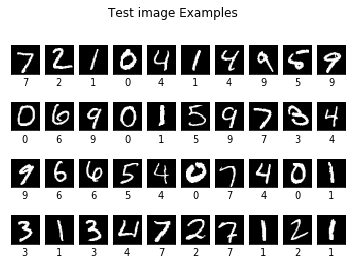

In [59]:
#show the first forty images
for i in range(40):
    l1_plot = plt.subplot(4, 10, i + 1)
    l1_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    #l1_plot.set_xlabel('Class %s' % y_test[i].decode())
    l1_plot.set_xlabel('%i' % int(y_test[i]))
plt.suptitle('Test image Examples')
plt.show()

In [60]:
## for this demonstration each pixel scale is normalized 
## by the mean and standared deviation of the training set
## note the mean and stadard deviation are set by the
## taining set only.
## why is this done?
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [61]:
#train and test classifier
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / 1000,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
# Train the classifier
clf.fit(X_train, y_train)

#Evaluate the classifier
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

Sparsity with L1 penalty: 18.41%
Test score with L1 penalty: 0.9024


In [62]:
## For analysis show also the confusion matrix

from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_predict)
print (cfm)

[[ 958    0    1    1    0    8    8    2    2    0]
 [   0 1103    3    3    1    2    4    0   19    0]
 [  14   15  889   25   15    0   12   22   36    4]
 [   5    4   18  901    1   32    7   17   17    8]
 [   2    8    4    0  915    2   12    2    3   34]
 [  13    6    4   36   17  747   20   15   27    7]
 [  15    6    8    0   11   19  895    1    3    0]
 [   2   24   20    4   11    0    1  929    1   36]
 [  11   21    9   27   20   34   11   17  807   17]
 [  17    8    3   13   48    8    0   27    5  880]]


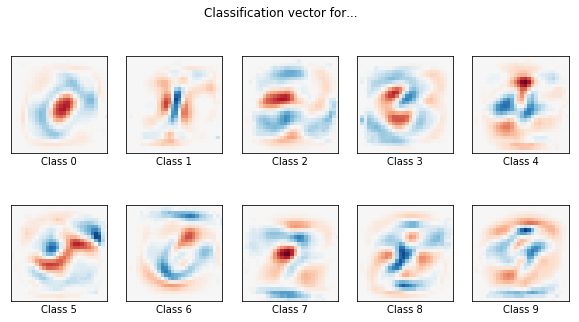

In [63]:
# Bonus 2: Visualization of the weights
# This is only possible for simple classifiers

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')
plt.show()

In [64]:
### Bonus 3: comfusion matrix visualization tool
## A more elegant preserntation for a confusion matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

Confusion matrix, without normalization


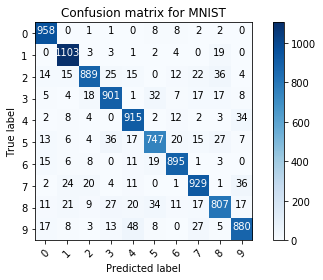

In [65]:
  plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix for MNIST')

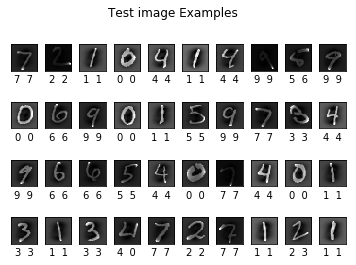

In [66]:
#show the first forty images
for i in range(40):
    l1_plot = plt.subplot(4, 10, i + 1)
    plt.subplots_adjust(wspace = .3, hspace = .3)
    l1_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    #l1_plot.set_xlabel('Class %s' % y_test[i].decode())
    l1_plot.set_xlabel('%i  %i' % (int(y_test[i]), int(y_predict[i])))
plt.suptitle('Test image Examples')
plt.show()

Read my own dataset

In [93]:
#create a class to help to read the image according to the cvs file
class SimpleDataset():
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = imageio.imread(self.data_path + single_image_name)
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        
        return (img_as_img, single_image_label)

    def __len__(self):
        return self.data_len

In [122]:
#read the image file 
mydata = SimpleDataset( "./idata/", "label.csv")
#mytestdata = SimpleDataset( "./idata/", "test.csv")
#splitting into images and labels 
X = []
y = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))

#converting into numpy arrays to enable easy reshaping and other array operations
    
X = np.asarray(X)
print("Shape of the input image", X.shape)
y= np.asarray(y)

Shape of the input image (60, 28, 28)


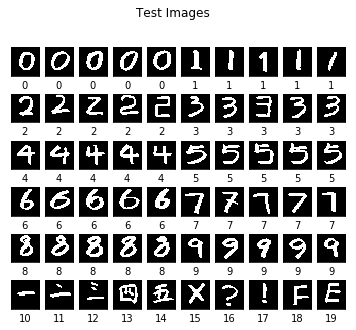

In [123]:
warnings.filterwarnings('ignore')
#l1_plot = plt.subplot(0, 5, i + 1)
plt.figure(figsize=(6,5))
for i in range(60):
    img_plot = plt.subplot(6, 10, i + 1)
    #plt.subplots_adjust(wspace = .3, hspace = .5)
    img_plot.imshow(255 * X[i].reshape(28, 28), interpolation="nearest",
                   cmap=plt.cm.gray)
    img_plot.set_xticks(())
    img_plot.set_yticks(())
    img_plot.set_xlabel('%i' % int(y[i]))
plt.suptitle('Test Images')
plt.show()



In [124]:
#reshaping the array into flattened 784 array as an input for prediciton by the logistic regression classifier
X = X.reshape(X.shape[0], 784)
X = X / 255.
#data standardiation with the training set statistics is required for this clasifier
X = scaler.transform(X)

y_pred = clf.predict(X)
#y_pred = y_pred.astype(np.int64)

# for i in range(y_pred.size):
#     y_pred[i] = int(y_pred[i])
# print(y_pred.size)

score = clf.score(X, y)

print("Test score with L1 penalty: %.4f" % score)
print("y_predicted_values", y_pred)
print("y_labels", y)




Test score with L1 penalty: 0.0000
y_predicted_values [b'0' b'0' b'0' b'0' b'0' b'1' b'1' b'1' b'1' b'1' b'2' b'6' b'2' b'6'
 b'6' b'2' b'3' b'6' b'3' b'3' b'9' b'9' b'4' b'9' b'4' b'0' b'0' b'0'
 b'0' b'0' b'6' b'0' b'6' b'6' b'6' b'7' b'8' b'3' b'7' b'3' b'6' b'6'
 b'6' b'6' b'3' b'9' b'7' b'9' b'9' b'9' b'4' b'4' b'2' b'6' b'2' b'1'
 b'2' b'1' b'8' b'6']
y_labels [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 11 12 13 14 15 16 17 18 19]


In [114]:
import array
import struct
y_pred[59] = (y_pred[59])
y_pred = y_pred.astype(np.int64)
print(y_pred[59])
#testResult = struct.unpack('>HH', y_pred[59])
type(y_pred[59])
type(y[59])

6


numpy.int64

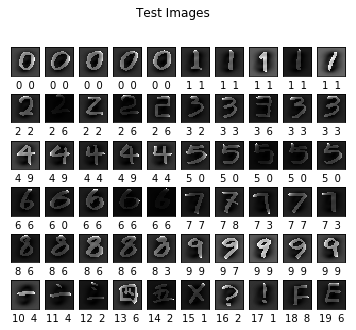

In [71]:
warnings.filterwarnings('ignore')
#l1_plot = plt.subplot(0, 5, i + 1)
plt.figure(figsize=(6,5))
for i in range(60):
    img_plot = plt.subplot(6, 10, i + 1)
   # plt.subplots_adjust(wspace = .3, hspace = .5)
    img_plot.imshow(255 * x[i].reshape(28, 28), interpolation="nearest",
                   cmap=plt.cm.gray)
    img_plot.set_xticks(())
    img_plot.set_yticks(())
    img_plot.set_xlabel('%i  %i' % (int(y[i]),int(y_pred[i])))
plt.suptitle('Test Images')
plt.show()